In [1]:
# Python program to explain cv2.imread() method 
  
# importing cv2  
import pandas as pd
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
from scipy import stats
from scipy.stats import poisson

from keras.models import load_model

import seaborn as sn
import itertools
from matplotlib.gridspec import GridSpec

import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

In [156]:
def two_plot_summary_v4(grid_data, data_from_patch, patch_lon, patch_lat, leg_loc, rad1, lon_lat=True):
    
    test_x = np.array(data_from_patch["test_x"])
    test_y = np.array(data_from_patch["test_y"])
    
    pred_x = np.array(data_from_patch["pred_x"])
    pred_y = np.array(data_from_patch["pred_y"])
    
    test_class = np.array(data_from_patch["class"])
    
    prob_agn  = np.array(data_from_patch["prob_agn"])
    prob_psr  = np.array(data_from_patch["prob_psr"])
    prob_fake = np.array(data_from_patch["prob_fake"])
    
    prob_loc =  np.array(data_from_patch["probability"])
    
    #print(test_x[0], pred_x[0])
    figure, ax = plt.subplots(1,2,figsize=(10, 10)) 
    
    ax[0].imshow(grid_data, origin='lower')

    for con in range(len(pred_x)):
            
        circle = plt.Circle((pred_x[con], pred_y[con]), rad1, fill=False, color="white")
        ax[0].add_artist(circle)
        ax[0].add_patch(circle) 
        
        square = plt.Rectangle((pred_x[con]-3, pred_y[con]-3), 6, 6, angle=0.0, fill=False, color="white")
        ax[0].add_artist(square)
        ax[0].add_patch(square) 
        
        #if (test_class[con] == 2):
        #    ax[0].text(pred_x[con]-2, pred_y[con]-1, f"{prob_loc[con]:0.1f}", color="white", fontweight='bold')
        
    con_cross_agn = 0
    con_cross_psr = 0
    for con in range(len(test_x)):    
        
        if test_class[con] == 0:
            con_cross_agn = con_cross_agn + 1
        
            crosses_agn, = ax[0].plot(test_x[con], test_y[con], 'x', color="red", label="Test PS",\
                                  mew=2, ms=10) #linewidth=3, markersize=10)
            
        if test_class[con] == 1:
            
            con_cross_psr = con_cross_psr + 1
        
            crosses_psr, = ax[0].plot(test_x[con], test_y[con], 'x', color="blue", label="Test PS",\
                                  mew=2, ms=10) #linewidth=20, markersize=10)
        
    if con_cross_agn > 0 and con_cross_psr > 0:    
        
        ax[0].legend([crosses_agn, crosses_psr, circle], ['True AGN', 'True PSR', 'UNEK PS'], loc=leg_loc)  
        
    if con_cross_agn > 0 and con_cross_psr == 0:    
        
        ax[0].legend([crosses_agn, circle], ['True AGN', 'UNEK PS'], loc=leg_loc)  
        
    if con_cross_agn == 0 and con_cross_psr >0 :    
        
        ax[0].legend([crosses_psr, circle], ['True PSR', 'UNEK PS'], loc=leg_loc)  
    
    
    ax[0].set_aspect(1)
    ax[0].set_xlim(-0.5,63.5)
    ax[0].set_ylim(-0.5,63.5)
    
    #######################################
    #PIE charts
    #######################################
               
    con_agn = 0
    con_psr = 0
    con_fake = 0
    
    size = 1000
    con_ps_class = 0
    
    mc_count = 0 
    
    #print("sources with classification", len(pred_x))
    
    for con in range(len(pred_x)):
        
        #print(prob_agn[con], prob_psr[con], prob_fake[con])
        
        if prob_agn[con] + prob_psr[con] + prob_fake[con] > 0:
        
            xpos = pred_x[con]
            ypos = pred_y[con]

            r1 = prob_agn[con]
            r2 = r1 + prob_psr[con]

            x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
            y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
            xy1 = np.column_stack([x, y])
            s1 = np.abs(xy1).max()

            x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 20)).tolist()
            y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 20)).tolist()
            xy2 = np.column_stack([x, y])
            s2 = np.abs(xy2).max()

            x = [0] + np.cos(np.linspace(2 * np.pi * r2, 2 * np.pi, 20)).tolist()
            y = [0] + np.sin(np.linspace(2 * np.pi * r2, 2 * np.pi, 20)).tolist()
            xy3 = np.column_stack([x, y])
            s3 = np.abs(xy3).max()
            
            ax[1].scatter(xpos, ypos, marker=xy1,
                          s=s1 ** 2 * size, facecolor='red')

            ax[1].scatter(xpos, ypos, marker=xy2,
                          s=s2 ** 2 * size, facecolor='blue')

            ax[1].scatter(xpos, ypos, marker=xy3,
                          s=s3 ** 2 * size, facecolor='magenta')
    
            if ((prob_agn[con] >= prob_psr[con]) & (prob_agn[con] >= prob_fake[con])):
                ax[1].text(xpos-2, ypos+1, f"{prob_agn[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=0.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1
                
            if ((prob_psr[con] > prob_agn[con]) & (prob_psr[con] >=prob_fake[con])):
                ax[1].text(xpos-4, ypos-1, f"{prob_psr[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=1.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1
                
            if ((prob_fake[con] > prob_agn[con]) & (prob_fake[con] > prob_psr[con])):
                ax[1].text(xpos-2, ypos-3, f"{prob_fake[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=2.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1

    #Legend
    agn_marker = ax[1].scatter(70, 70, marker="o", s=40, color="red")
    psr_marker = ax[1].scatter(70, 70, marker="o", s=40, color="blue")
    fake_marker = ax[1].scatter(70, 70, marker="o", s=40, color="magenta")
    
    mis_class = ax[1].scatter(70, 70, marker="_", s=40, color="black")
    
    if mc_count > 0:
    
        ax[1].legend([agn_marker, psr_marker, fake_marker, mis_class], ["AGN Prob (%)", "PSR Prob (%)", \
                                                                        "FAKE Prob (%)", "Misclassified"],\
                                                                          fontsize = 11, loc=leg_loc)
    if mc_count == 0:
    
        ax[1].legend([agn_marker, psr_marker, fake_marker], ["AGN Prob (%)", "PSR Prob (%)", \
                                                                        "FAKE Prob (%)"],\
                                                                          fontsize = 11, loc=leg_loc)
        
            
    ax[1].set_aspect(1)
    ax[1].set_xlim(0,64)
    ax[1].set_ylim(0,64)

    #AXIS values
    for con in range(2):
    
        ax[con].set_xticks([0,10,20,30,40,50,60])
        ax[con].set_yticks([0,10,20,30,40,50,60])
        
    if lon_lat:  
    
        lon_xaxis = []    
        lat_yaxis = []

        for decs in range(7):
            yval = 0
            xval = 10*decs

            lon_ps, lat_ps = get_lb_from_pixel(pixel_id(yval*2, xval*2,128), [patch_lon, patch_lat])

            lon_xaxis.append("% .0f"% lon_ps)

            yval = 10*decs
            xval = 0

            lon_ps, lat_ps = get_lb_from_pixel(pixel_id(yval*2, xval*2,128), [patch_lon, patch_lat])

            lat_yaxis.append("% .0f"% lat_ps)

            #print(lon_ps, lat_ps)

        for con in range(2):    

            ax[con].set_xticklabels(lon_xaxis)
            ax[con].set_yticklabels(lat_yaxis)

            ax[con].set_xlabel("Galactic Longitude (°)", fontsize = 14)
            ax[con].set_ylabel("Galactic Latitude (°)", fontsize = 14)
    else:
        for con in range(2):    

            ax[con].set_xlabel("x-pixels", fontsize = 14)
            ax[con].set_ylabel("y-pixels", fontsize = 14)
    
    
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)
    plt.show()
    
    return

In [134]:
def patch_two_plots(patch, radius, lon_lat, legend_loc):
    
    print(patch)

    test_asimov = np.load(f"{path_to_test}/test_image_{patch}.npy")
    test_mask = np.load(f"{path_to_test}/test_masks_{patch}.npy")

    test_asimov_sum = np.sum(test_asimov, axis=0)
    test_poisson = np.random.poisson(test_asimov_sum)

    data_from_patch = stat_file[((stat_file["patch_number"]==patch) & (stat_file["stat_code"]!=3))]
    id_class = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,13]
    position = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,11:13]
    distance_dg = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,6]
    snr_center = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,-5]

    #prediction of classes
    #classify the point sources in poisson patch
    ps_patch_asimov_list, ps_patch_poisson_list, ps_pred_list = classify_patch_stat(f"test_image_{patch}.npy",
                                                                                    test_asimov_sum, position, 
                                                                                    id_class, distance_dg, 
                                                                                    cnn_model, snr_center)

    print(test_asimov_sum.shape)
    print("Patch center at lon = %.2f and lat = %.2f"%(data_from_patch["test_lon_patch"].iloc[0],\
                                                       data_from_patch["test_lat_patch"].iloc[0]))

    prob_pred_df = pd.DataFrame({"prob_agn":ps_pred_list[:,10], "prob_psr":ps_pred_list[:,11],\
                                "prob_fake":ps_pred_list[:,12]})

    data_from_patch = data_from_patch.reset_index()

    data_from_patch_prob = pd.concat([data_from_patch, prob_pred_df], axis=1)

    two_plot_summary_v4(test_poisson[:,:,1], data_from_patch_prob, data_from_patch["test_lon_patch"].iloc[0],\
                        data_from_patch["test_lat_patch"].iloc[0], legend_loc, radius, lon_lat)

In [4]:
def RotMatrixY(psi, isdeg = True):
    if isdeg:
        return np.array([[np.cos(np.radians(psi)), 0.0, -np.sin(np.radians(psi))],[0.0, 1.0, 0.0],\
                         [np.sin(np.radians(psi)), 0.0, np.cos(np.radians(psi))]])
    else:
        return np.array([[np.cos(psi), 0.0, -np.sin(psi)],[0.0, 1.0, 0.0],[np.sin(psi), 0.0, np.cos(psi)]]) 
    
def RotMatrixZ(psi, isdeg = True):
    if isdeg:
        return np.array([[np.cos(np.radians(psi)), np.sin(np.radians(psi)), 0.0],\
                         [-np.sin(np.radians(psi)), np.cos(np.radians(psi)), 0.0],[0.0, 0.0, 1.0]])
    else:
        return np.array([[np.cos(psi), np.sin(psi), 0.0],[-np.sin(psi), np.cos(psi), 0.0],[0.0, 0.0, 1.0]])
    
def sph2xyz(r, theta, phi, isdeg = True):
    if isdeg:
        return np.array([r*np.sin(np.radians(theta))*np.cos(np.radians(phi)), \
                         r*np.sin(np.radians(theta))*np.sin(np.radians(phi)), r*np.cos(np.radians(theta))])
    else:
        return np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)])
    
def xyz2sph(x, y, z, isdeg= True, is_lat = False):
    r = np.sqrt(x*x + y*y + z*z)
    if isdeg:
        phi = np.degrees(np.arctan2(y,x))
        lat = np.degrees(np.arctan2(z, np.sqrt(x*x + y*y)))
        if is_lat:
            return np.array([r, lat, phi])
        else:
            return np.array([r, 90. - lat, phi])
    else:
        phi = np.arctan2(y,x)
        lat = np.arctan2(z, np.sqrt(x*x + y*y))
        if is_lat:
            return np.array([r, lat, phi])
        else:
            return np.array([r, np.pi/2.0 - lat, phi])

def get_lb_from_pixel(pixel_id, lb_centre, xsize=128, isdeg = True, is_lat = True): ##if input angles are in degree use 'isdeg = True'
######### Generate (l,b) coordinate map of 10x10deg patch ######
    
    #Following the suggestions of CA mail
    if (xsize == 100):
        coord_range = np.linspace(-4.95, 4.95, xsize)
    
    if (xsize == 128):
        coord_range = np.linspace(-4.9609375, 4.9609375, xsize)
    
    X, Y = np.meshgrid(coord_range, coord_range)
    lonlat_patch = list(zip(np.flip(X.flatten()), Y.flatten()))
    ######### Get rotation matrix used to rotate the original centre to (0., 0.) #########
    l_centre, b_centre = lb_centre
    r = np.dot(RotMatrixY(-b_centre), RotMatrixZ(l_centre))
    ######### 
    
    lon_PS_rotated, lat_PS_rotated = lonlat_patch[int(pixel_id)]
     
    #x_pixel_normal = int(pixel_id % xsize)
    #y_pixel_normal = int(pixel_id / xsize)
        
    xyz_PS_rotated = sph2xyz(1., 90. - lat_PS_rotated, lon_PS_rotated)
    x_PS, y_PS, z_PS = np.array(np.dot(r.T, xyz_PS_rotated), dtype = 'float32')
    #xyz_centre = sph2xyz(1., 90. - b_centre, l_centre)
    r, b_PS, l_PS = xyz2sph(x_PS, y_PS, z_PS, isdeg = isdeg, is_lat = is_lat)
    
    if l_PS < 0:
        l_PS = 360 + l_PS
    
    return l_PS, b_PS

def pixel_id(row, col, xsize_patch):
    
    return xsize_patch*row + col

#### Classify point sources using the info from stat files

In [5]:
def get_samples(ims):
    return (poisson.rvs(ims) - norm_mean) / norm_std

def classify_patch_stat(patch, test_image_npy, ps_position, id_class, distance_dg, cnn_model, snr_center):
    
    image_name = f"test_image_{patch}.npy"
    
    #dimensions of test_image_poisson
    xsize = 64
    
    #box dimensions
    r_b=7
    box_inf = 3
    box_sup = 4
    
    #number of point source with positions in xmin, xmax, ymin, ymax format
    ps_length = len(ps_position)
    
    #list of point source patches when is possible
    ps_patch_asimov_list = np.zeros((ps_length, 7, 7, 5))
    ps_patch_poisson_list = np.zeros((ps_length, 7, 7, 5))
    
    #list of test adn predictions and extra data to compare with ROC-AUC data
    ps_pred_list = np.zeros((ps_length, 15), dtype=object)
    
    for ps_number in range(ps_length):
    
        #print(id_class)
        #print(ps_number, ps_length, id_class.iloc[ps_number])
        id_ps = id_class.iloc[ps_number]

        x_ps = int(ps_position["pred_x"].iloc[ps_number])
        y_ps = int(ps_position["pred_y"].iloc[ps_number])

        snr_ct = snr_center.iloc[ps_number]
        
        #box around ps, for radius of 7x7
        #xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-box_inf),min(xsize-1,x_ps+box_sup),\
        #                                 max(0,y_ps-box_inf),min(xsize-1,y_ps+box_sup)

        #improved version of the cut. here we correctly consider superior limits inclusively
        xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-box_inf),min(xsize,x_ps+box_inf+1),\
                                         max(0,y_ps-box_inf),min(xsize,y_ps+box_inf+1)

        
        prob_test_agn = 0
        prob_test_psr = 0
        prob_test_fake = 0
        
        ps_pred_list[ps_number,0] = image_name
        ps_pred_list[ps_number,1] = id_ps
        ps_pred_list[ps_number,2] = x_ps
        ps_pred_list[ps_number,3] = x_ps
        ps_pred_list[ps_number,4] = y_ps
        ps_pred_list[ps_number,5] = y_ps
        ps_pred_list[ps_number,13] = distance_dg.iloc[ps_number]
        ps_pred_list[ps_number,14] = snr_center.iloc[ps_number]
        
        ps_patch_test = np.zeros((1,7,7,5))
        
        #if ( x_ps >= 3 or x_ps <= 61 or y_ps >= 3 or y_ps <= 61 ):
        if (((xmax_b-xmin_b) == r_b) and ((ymax_b-ymin_b) == r_b)):
            #ps patch from 64x64 asimov (for future comparison) and poisson patch  
            ps_patch_asimov = test_image_npy[ymin_b:ymax_b, xmin_b:xmax_b]
            
            #ps_patch_poisson = np.random.poisson(ps_patch_asimov, ps_patch_asimov.shape).astype(float)
            ps_patch_poisson = (poisson.rvs(ps_patch_asimov) - norm_mean) / norm_std
            
            #dataset with one position just to evaluate with cnn_predict
            ps_patch_test[0,:,:,:] = ps_patch_poisson[:,:,:]
            
            #list of patches for future use
            ps_patch_asimov_list[ps_number, :, :, :] = ps_patch_asimov[:,:,:]
            ps_patch_poisson_list[ps_number, :, :, :] = ps_patch_poisson[:,:,:]
            
            #one-hot encoder of test id_class
            if int(id_ps) == 0:
                prob_test_agn = 1
            if int(id_ps) == 1:   
                prob_test_psr = 1
            if int(id_ps) == 2:
                prob_test_fake = 1
                
            #cnn prediction on one ps patch
            ps_pred_prob = cnn_model.predict(ps_patch_test)
                
            ps_pred_list[ps_number,6] = 1 #7x7 box
            
            ps_pred_list[ps_number,7] = prob_test_agn
            ps_pred_list[ps_number,8] = prob_test_psr
            ps_pred_list[ps_number,9] = prob_test_fake
                
            ps_pred_list[ps_number,10] = ps_pred_prob[0,0]
            ps_pred_list[ps_number,11] = ps_pred_prob[0,1]
            ps_pred_list[ps_number,12] = ps_pred_prob[0,2]
            
            
        else:
            ps_pred_list[ps_number,6] = 0
            
    return ps_patch_asimov_list, ps_patch_poisson_list, ps_pred_list

In [6]:
xsize  = 64

path_solid = f"/home/bapanes/Research-Now/local/centroidnet-gr-local/data-solid"

#cnn_model_file = f"{path_to_solid}/models/cnn_fit_generator_10k_v2_100e_v2.h5"
#pkl_file = f"{path_to_solid}/models/local_unbalanced_standard_norm_vals.pkl"

#cnn_model_file = f"{path_solid}/models/cnn_fit_generator_10k_100e_v24.h5"

cnn_model_file = f"{path_solid}/models/cnn_fit_generator_10k_500e_v28.h5"
pkl_file = f"{path_solid}/models/random_unbalanced_corrected_standard_norm_vals.pkl"

In [7]:
with open(pkl_file,"rb") as f:
    [norm_mean, norm_std] = pickle.load(f)

In [44]:
path_to_test = f"{path_solid}/data-test/data-768-F0-B1"

path_to_test_csv = f"{path_to_test}/test.csv"
path_to_stat_csv = f"{path_solid}/results-unek-100k/unek_evaluation_f0_b1_solid.csv"
#path_to_stat_csv = f"{path_solid}/data-cnet/results-100k-new/cnet_evaluation_F0_B1_b1_th1.csv"

In [45]:
cnn_model = load_model(cnn_model_file)

In [46]:
stat_file = pd.read_csv(f"{path_to_stat_csv}", sep=",")

In [47]:
stat_file[((stat_file["stat_code"]==1))]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
8,1.0,8.0,317.628300,84.026299,342.493141,82.612706,3.185082,21.377558,1.350665e-10,235.0,1.0,31.0,30.0,2.0,27.0,9.0,-45.0,84.149733,0.202133,2.118629e-11,0.004820,0.0,0.732515,0.001787,0.366302
29,1.0,29.0,107.265121,81.501602,116.609443,83.529456,2.358704,15.264338,2.440150e-09,235.0,3.0,21.0,57.0,2.0,29.0,44.0,135.0,84.149733,0.346618,8.811912e-11,0.829942,0.0,8.615405,0.382801,16.638969
33,1.0,33.0,91.872391,83.766731,91.774419,83.401266,0.365629,2.236068,1.129063e-10,235.0,3.0,40.0,59.0,2.0,38.0,60.0,135.0,84.149733,0.588526,2.843863e-12,1.134656,0.0,1.523920,0.526935,1.000752
34,1.0,34.0,191.834167,84.263741,197.376721,85.439033,1.274873,7.211103,3.922314e-10,235.0,3.0,49.0,1.0,2.0,55.0,5.0,135.0,84.149733,0.754042,9.753412e-11,4.467314,0.0,1.619577,2.026019,1.075939
65,1.0,65.0,14.551717,82.944283,28.958216,74.650075,8.690894,55.973208,1.120414e-10,235.0,8.0,62.0,38.0,2.0,9.0,20.0,22.5,78.284148,0.575231,1.807986e-11,10.488920,0.0,0.981265,4.997164,0.484775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5570,1.0,5570.0,298.938210,-73.456482,316.643474,-82.375478,9.557657,60.671245,2.640005e-11,235.0,758.0,62.0,20.0,2.0,2.0,11.0,-67.5,-78.284148,0.268928,1.073967e-13,2.246771,0.0,1.111974,1.042749,0.672157
5595,1.0,5595.0,90.817352,-77.545204,89.326603,-77.343901,0.381483,1.000000,3.281028e-10,235.0,762.0,31.0,61.0,2.0,31.0,62.0,112.5,-78.284148,0.945800,3.011835e-11,1.480936,0.0,2.966861,0.715475,2.773502
5601,1.0,5601.0,187.106445,-79.932343,166.396141,-79.038096,3.861157,23.853721,7.332271e-10,235.0,763.0,13.0,0.0,2.0,26.0,20.0,157.5,-78.284148,0.521601,4.594817e-11,10.846408,0.0,3.131681,5.380922,2.930976
5608,1.0,5608.0,153.586304,-75.556160,156.454541,-74.310477,1.451405,9.433981,4.548861e-10,235.0,763.0,49.0,38.0,2.0,57.0,33.0,157.5,-78.284148,0.220462,1.080811e-11,0.086519,0.0,3.177099,0.042344,3.195107


### Full pipeline plots

#### High Latitude (>45 degrees)

647
(64, 64, 5)
Patch center at lon = 84.38 and lat = -41.81


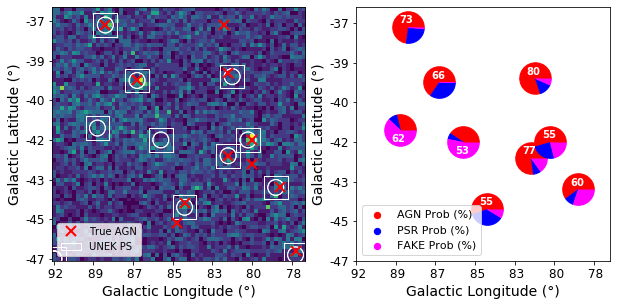

In [162]:
patch_two_plots(647, 2, True, "lower left")

647
(64, 64, 5)
Patch center at lon = 84.38 and lat = -41.81


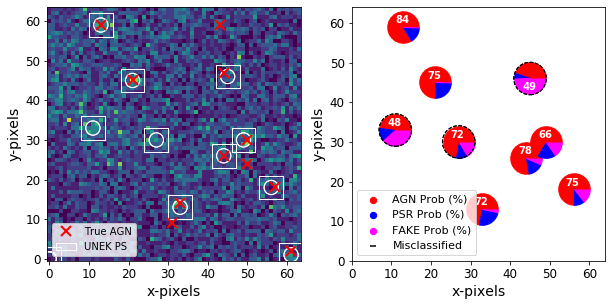

In [158]:
patch_two_plots(647, 1.8, False, "lower left")

In [123]:
stat_file[stat_file["patch_number"]==647]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
4791,0.0,4791.0,77.758568,-46.439091,77.587092,-46.397354,0.125365,1.000000,1.860717e-10,235.0,647.0,1.0,61.0,0.0,2.0,61.0,84.375,-41.810315,0.337483,2.840735e-11,2.167725,0.0,0.804673,0.773911,0.332129
4792,0.0,4792.0,84.100388,-44.739689,83.968561,-44.579992,0.185190,1.000000,3.983565e-10,235.0,647.0,13.0,33.0,0.0,14.0,33.0,84.375,-41.810315,0.878672,3.609188e-12,1.618953,0.0,1.730510,0.598335,0.878236
4793,0.0,4793.0,79.121628,-43.842953,78.909759,-43.688419,0.217466,1.000000,1.126784e-10,235.0,647.0,18.0,56.0,0.0,18.0,57.0,84.375,-41.810315,0.410630,7.262999e-12,0.917814,0.0,0.799068,0.319040,0.319040
4794,0.0,4794.0,81.771278,-42.679756,81.651985,-42.646462,0.093828,0.000000,1.700300e-10,235.0,647.0,26.0,44.0,0.0,26.0,44.0,84.375,-41.810315,0.916452,1.690400e-11,2.337137,0.0,1.727992,0.829300,0.829300
4795,1.0,4795.0,85.374969,-42.079430,86.509907,-39.650097,2.576427,16.155494,8.325052e-10,235.0,647.0,30.0,27.0,2.0,45.0,21.0,84.375,-41.810315,0.203361,7.885723e-11,0.019572,0.0,5.142611,0.006054,4.547787
4796,0.0,4796.0,80.745514,-42.026836,80.443186,-41.930017,0.244717,1.000000,3.589114e-10,235.0,647.0,30.0,49.0,0.0,30.0,50.0,84.375,-41.810315,0.898101,8.288425e-15,2.953879,0.0,2.125742,1.058356,1.088505
4797,1.0,4797.0,88.707954,-41.533279,86.509907,-39.650097,2.516227,15.620499,8.325052e-10,235.0,647.0,33.0,11.0,2.0,45.0,21.0,84.375,-41.810315,0.960459,7.885723e-11,0.011885,0.0,5.142611,0.003075,4.547787
4798,0.0,4798.0,86.557495,-39.718674,86.509907,-39.650097,0.077743,0.000000,8.325052e-10,235.0,647.0,45.0,21.0,0.0,45.0,21.0,84.375,-41.810315,0.999520,7.885723e-11,12.110659,0.0,5.142611,4.547787,4.547787
4799,0.0,4799.0,81.691582,-39.551430,81.703529,-39.390386,0.161308,1.414214,3.056901e-10,235.0,647.0,46.0,45.0,0.0,47.0,44.0,84.375,-41.810315,0.785820,4.502849e-12,3.486893,0.0,1.351832,1.337756,0.668139
4800,0.0,4800.0,88.058022,-37.489723,87.929361,-37.368413,0.158603,0.000000,5.958646e-10,235.0,647.0,59.0,13.0,0.0,59.0,13.0,84.375,-41.810315,0.994616,7.023711e-12,2.754324,0.0,1.980282,0.942127,0.942127


#### Low latitude (<10 degrees)

408
(64, 64, 5)
Patch center at lon = -90.00 and lat = -4.78


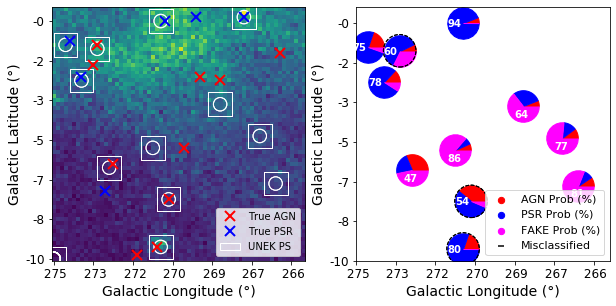

In [168]:
patch_two_plots(408, 1.7, True, "lower right")

408
(64, 64, 5)
Patch center at lon = -90.00 and lat = -4.78


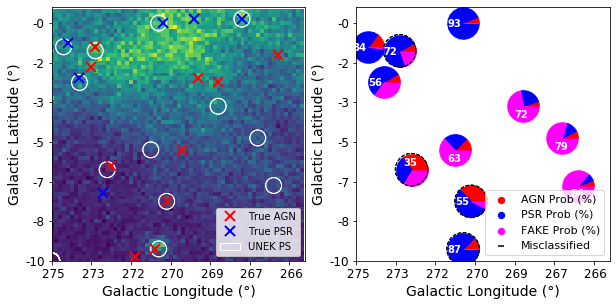

In [125]:
patch_two_plots(408, 2, True)

In [109]:
stat_file[stat_file["patch_number"]==408]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
3087,0.0,3087.0,270.749710,-9.271975,270.777193,-9.164629,0.110720,1.000000,4.900078e-09,235.0,408.0,3.0,27.0,0.0,3.0,26.0,-90.0,-4.780192,0.999959,1.281009e-10,19.772136,0.0,9.246270,3.573239,3.573239
3088,0.0,3088.0,270.432846,-7.397243,270.346018,-7.350454,0.098001,0.000000,9.405236e-10,235.0,408.0,15.0,29.0,0.0,15.0,29.0,-90.0,-4.780192,0.999018,6.113503e-11,6.708880,0.0,4.651083,1.081082,1.081082
3089,1.0,3089.0,266.186676,-6.761875,269.799534,-5.336643,3.865014,24.698178,2.059360e-10,235.0,408.0,19.0,56.0,2.0,28.0,33.0,-90.0,-4.780192,0.242715,3.112288e-11,0.002210,0.0,1.204557,0.000292,0.166175
3090,1.0,3090.0,272.788673,-6.141756,272.593962,-5.872349,0.331779,1.414214,2.740502e-10,235.0,408.0,23.0,14.0,2.0,24.0,15.0,-90.0,-4.780192,0.236872,7.145110e-12,0.454340,0.0,1.348771,0.081341,0.266672
3091,1.0,3091.0,271.059273,-5.365316,269.799534,-5.336643,1.254577,8.000000,2.059360e-10,235.0,408.0,28.0,25.0,2.0,28.0,33.0,-90.0,-4.780192,0.208437,3.112288e-11,0.022770,0.0,1.204557,0.002899,0.166175
3092,1.0,3092.0,266.824379,-4.890074,268.376825,-2.619282,2.748805,17.204651,3.646440e-10,235.0,408.0,31.0,52.0,2.0,45.0,42.0,-90.0,-4.780192,0.305229,7.545410e-12,0.004155,0.0,1.196463,0.000515,0.116599
3093,1.0,3093.0,268.395508,-3.645511,268.376825,-2.619282,1.026398,6.000000,3.646440e-10,235.0,408.0,39.0,42.0,2.0,45.0,42.0,-90.0,-4.780192,0.253819,7.545410e-12,0.047146,0.0,1.196463,0.004612,0.116599
3094,0.0,3094.0,273.868965,-2.699003,273.824350,-2.537738,0.167310,1.000000,8.266006e-10,235.0,408.0,45.0,7.0,1.0,46.0,7.0,-90.0,-4.780192,0.264744,1.560508e-12,2.730611,1.0,2.730611,0.319742,0.319742
3095,0.0,3095.0,273.237785,-1.452247,273.196922,-1.295788,0.161705,1.000000,1.177174e-09,235.0,408.0,53.0,11.0,0.0,54.0,11.0,-90.0,-4.780192,0.968396,5.616011e-11,3.946968,0.0,1.924147,0.338662,0.184785
3096,0.0,3096.0,274.485046,-1.288985,274.322787,-1.133615,0.224625,1.414214,1.247330e-09,235.0,408.0,54.0,3.0,1.0,55.0,4.0,-90.0,-4.780192,0.996123,1.258732e-10,4.073937,1.0,2.993362,0.479117,0.341945


#### Checks

Notice that data_from_patch is the output of the evaluation algorithm, previous to any classification. So, this is the stage where we match TP, FP and FN pairs. 

In [30]:
def distance_degrees(lon1, lat1, lon2, lat2):

    ra_1 = lon1*u.degree
    de_1 = lat1*u.degree
                    
    ra_2 = lon2*u.degree
    de_2 = lat2*u.degree
                    
    c1 = SkyCoord(ra = ra_1, dec = de_1)
    c2 = SkyCoord(ra = ra_2, dec = de_2)
        
    distance_c1c2 = c1.separation(c2).degree

    return distance_c1c2 

#### Notice that the point source predicted around the pixel (y,x) = (23,14) is indeed at more than 0.3 degrees with respect to the nearest one. Indeed the classification is ok, because is a false positive since there is not associated ps at less than 0.3

Maybe we could reduce the size of the circle to consider this situation

In [22]:
data_from_patch[data_from_patch["stat_code"]==1.0]

,index,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
2,3089,1.0,3089.0,266.186676,-6.761875,269.799534,-5.336643,3.865014,24.698178,2.059360e-10,235.0,408.0,19.0,56.0,2.0,28.0,33.0,-90.0,-4.780192,0.242715,3.112288e-11,0.002210,0.0,1.204557,0.000292,0.166175
3,3090,1.0,3090.0,272.788673,-6.141756,272.593962,-5.872349,0.331779,1.414214,2.740502e-10,235.0,408.0,23.0,14.0,2.0,24.0,15.0,-90.0,-4.780192,0.236872,7.145110e-12,0.454340,0.0,1.348771,0.081341,0.266672
4,3091,1.0,3091.0,271.059273,-5.365316,269.799534,-5.336643,1.254577,8.000000,2.059360e-10,235.0,408.0,28.0,25.0,2.0,28.0,33.0,-90.0,-4.780192,0.208437,3.112288e-11,0.022770,0.0,1.204557,0.002899,0.166175
5,3092,1.0,3092.0,266.824379,-4.890074,268.376825,-2.619282,2.748805,17.204651,3.646440e-10,235.0,408.0,31.0,52.0,2.0,45.0,42.0,-90.0,-4.780192,0.305229,7.545410e-12,0.004155,0.0,1.196463,0.000515,0.116599
6,3093,1.0,3093.0,268.395508,-3.645511,268.376825,-2.619282,1.026398,6.000000,3.646440e-10,235.0,408.0,39.0,42.0,2.0,45.0,42.0,-90.0,-4.780192,0.253819,7.545410e-12,0.047146,0.0,1.196463,0.004612,0.116599


In [31]:
distance_degrees(272.788673, -6.141756, 272.593962, -5.872349)

0.3317788788149556

#### Now, let us consider the 7x7 boxes around true possitives

In [29]:
data_from_patch[data_from_patch["stat_code"]==0.0]

,index,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
0,3087,0.0,3087.0,270.749710,-9.271975,270.777193,-9.164629,0.110720,1.000000,4.900078e-09,235.0,408.0,3.0,27.0,0.0,3.0,26.0,-90.0,-4.780192,0.999959,1.281009e-10,19.772136,0.0,9.246270,3.573239,3.573239
1,3088,0.0,3088.0,270.432846,-7.397243,270.346018,-7.350454,0.098001,0.000000,9.405236e-10,235.0,408.0,15.0,29.0,0.0,15.0,29.0,-90.0,-4.780192,0.999018,6.113503e-11,6.708880,0.0,4.651083,1.081082,1.081082
7,3094,0.0,3094.0,273.868965,-2.699003,273.824350,-2.537738,0.167310,1.000000,8.266006e-10,235.0,408.0,45.0,7.0,1.0,46.0,7.0,-90.0,-4.780192,0.264744,1.560508e-12,2.730611,1.0,2.730611,0.319742,0.319742
8,3095,0.0,3095.0,273.237785,-1.452247,273.196922,-1.295788,0.161705,1.000000,1.177174e-09,235.0,408.0,53.0,11.0,0.0,54.0,11.0,-90.0,-4.780192,0.968396,5.616011e-11,3.946968,0.0,1.924147,0.338662,0.184785
9,3096,0.0,3096.0,274.485046,-1.288985,274.322787,-1.133615,0.224625,1.414214,1.247330e-09,235.0,408.0,54.0,3.0,1.0,55.0,4.0,-90.0,-4.780192,0.996123,1.258732e-10,4.073937,1.0,2.993362,0.479117,0.341945
10,3097,0.0,3097.0,270.740005,-0.365730,270.581863,-0.250891,0.195438,1.000000,3.106317e-09,235.0,408.0,60.0,27.0,1.0,60.0,28.0,-90.0,-4.780192,0.999990,6.472027e-10,4.750706,1.0,9.316678,0.459466,1.069213
11,3098,0.0,3098.0,267.469009,-0.205207,267.329431,0.026903,0.270845,0.000000,2.604776e-09,235.0,408.0,61.0,48.0,1.0,61.0,48.0,-90.0,-4.780192,0.873527,3.131693e-12,6.160631,1.0,6.160631,0.718935,0.718935


#### the point source at (54,3) is aready considered as a valid source for classification. However, the source at (60, 27) it is not

let see if this is consistent

we notice that the routine for building the pie chart already receives a predicted point source with probs=0 in all entries for the ps at (60,27). thus the problem is not here. actually we need to go to data_from_patch_prob to see this information. indeed, we see that the probs are 0 here, this is nice because we do not have to mess the visualization routine but the classification one, classify_patch_stat

In [36]:
data_from_patch_prob[data_from_patch_prob["stat_code"]==0.0]

,index,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test,prob_agn,prob_psr,prob_fake
0,3087,0.0,3087.0,270.749710,-9.271975,270.777193,-9.164629,0.110720,1.000000,4.900078e-09,235.0,408.0,3.0,27.0,0.0,3.0,26.0,-90.0,-4.780192,0.999959,1.281009e-10,19.772136,0.0,9.246270,3.573239,3.573239,0.182224,0.81766,0.000115567
1,3088,0.0,3088.0,270.432846,-7.397243,270.346018,-7.350454,0.098001,0.000000,9.405236e-10,235.0,408.0,15.0,29.0,0.0,15.0,29.0,-90.0,-4.780192,0.999018,6.113503e-11,6.708880,0.0,4.651083,1.081082,1.081082,0.41317,0.571181,0.0156487
7,3094,0.0,3094.0,273.868965,-2.699003,273.824350,-2.537738,0.167310,1.000000,8.266006e-10,235.0,408.0,45.0,7.0,1.0,46.0,7.0,-90.0,-4.780192,0.264744,1.560508e-12,2.730611,1.0,2.730611,0.319742,0.319742,0.0980193,0.49298,0.409
8,3095,0.0,3095.0,273.237785,-1.452247,273.196922,-1.295788,0.161705,1.000000,1.177174e-09,235.0,408.0,53.0,11.0,0.0,54.0,11.0,-90.0,-4.780192,0.968396,5.616011e-11,3.946968,0.0,1.924147,0.338662,0.184785,0.120802,0.757934,0.121264
9,3096,0.0,3096.0,274.485046,-1.288985,274.322787,-1.133615,0.224625,1.414214,1.247330e-09,235.0,408.0,54.0,3.0,1.0,55.0,4.0,-90.0,-4.780192,0.996123,1.258732e-10,4.073937,1.0,2.993362,0.479117,0.341945,0.100011,0.860606,0.0393825
10,3097,0.0,3097.0,270.740005,-0.365730,270.581863,-0.250891,0.195438,1.000000,3.106317e-09,235.0,408.0,60.0,27.0,1.0,60.0,28.0,-90.0,-4.780192,0.999990,6.472027e-10,4.750706,1.0,9.316678,0.459466,1.069213,0,0,0
11,3098,0.0,3098.0,267.469009,-0.205207,267.329431,0.026903,0.270845,0.000000,2.604776e-09,235.0,408.0,61.0,48.0,1.0,61.0,48.0,-90.0,-4.780192,0.873527,3.131693e-12,6.160631,1.0,6.160631,0.718935,0.718935,0,0,0


#### Here we reproduce the condition for the box requirement

which is consistent with the outputs of the visualization plot. so, what is going on then?

In [120]:
#box dimensions

#y_ps = 60
#x_ps = 27 

#y_ps = 54
#x_ps = 3 

def visualize_one_np(grid1):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(grid1, origin='lower')
    #plt.axis('off')
    plt.show()

def box_condition(y_ps,x_ps,test_image_npy):

    r_b=7
    box_inf = 3
    box_sup = 4

    #box around ps, for radius of 7x7
    xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-box_inf),min(xsize-1,x_ps+box_sup),\
                                     max(0,y_ps-box_inf),min(xsize-1,y_ps+box_sup)

    print(xmin_b, xmax_b, ymin_b, ymax_b)

    if (((xmax_b-xmin_b) == r_b) and ((ymax_b-ymin_b) == r_b)):

        print("there is a 7x7 box around")
        
        ps_patch_asimov = test_image_npy[ymin_b:ymax_b, xmin_b:xmax_b]
         
        visualize_one_np(ps_patch_asimov[:,:,0])
    else:
        print("No 7x7 box")
        
def box_condition_v2(y_ps,x_ps,test_image_npy):

    r_b=7
    min_pixels= 3
    
    #box around ps, for radius of 7x7
    xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-min_pixels),min(xsize,x_ps+min_pixels+1),\
                                     max(0,y_ps-min_pixels),min(xsize,y_ps+min_pixels+1)

    print(xmin_b, xmax_b, ymin_b, ymax_b)

    if (((xmax_b-xmin_b) == r_b) and ((ymax_b-ymin_b) == r_b)):

        print("there is a 7x7 box around")
        
        ps_patch_asimov = test_image_npy[ymin_b:ymax_b, xmin_b:xmax_b]
         
        visualize_one_np(ps_patch_asimov[:,:,0])
    else:
        print("No 7x7 box")

0 7 51 58
there is a 7x7 box around


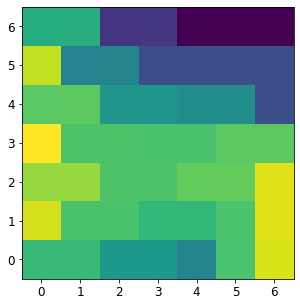

In [121]:
box_condition(54,3,test_asimov_sum)

In [122]:
box_condition(60,27,test_asimov_sum)

24 31 57 63
No 7x7 box


#### The algorithm is working fine. However, theres is an asymmetry between inferior and superior limits that is producing a strange effect for these two particular cases. 

For the point source which is in the left side (54,3) we require the existence of 3 bins to the left, while for the ps at the top (60,27) we are requiring 4 bins above

0 7 50 57
there is a 7x7 box around


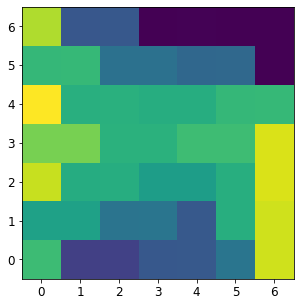

In [123]:
box_condition_symmetric(54,3,test_asimov_sum)

24 31 56 63
there is a 7x7 box around


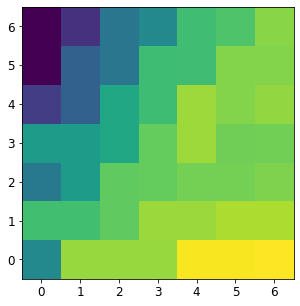

In [124]:
box_condition_symmetric(60,27,test_asimov_sum)

In [125]:
box_condition_v2(61,4,test_asimov_sum)

1 8 58 64
No 7x7 box


24 31 57 64
there is a 7x7 box around


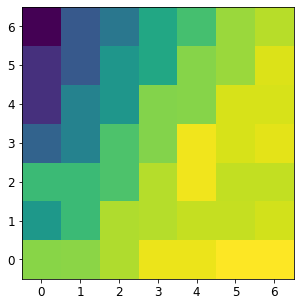

In [126]:
box_condition_v2(60,27,test_asimov_sum)

### can we find borderline sources in other patches?

In [26]:
import healpy as hp

In [27]:
longitude, latitude = hp.pix2ang(8, np.arange(hp.nside2npix(8)),lonlat=True)

In [72]:
for con in range(len(longitude)):
    print("%d, %.2f, %.2f, %.2f, %.2f"%(con, latitude[con], longitude[con], longitude[con]-180, (longitude[con] + 180) % 360 - 180))

0, 84.15, 45.00, -135.00, 45.00
1, 84.15, 135.00, -45.00, 135.00
2, 84.15, 225.00, 45.00, -135.00
3, 84.15, 315.00, 135.00, -45.00
4, 78.28, 22.50, -157.50, 22.50
5, 78.28, 67.50, -112.50, 67.50
6, 78.28, 112.50, -67.50, 112.50
7, 78.28, 157.50, -22.50, 157.50
8, 78.28, 202.50, 22.50, -157.50
9, 78.28, 247.50, 67.50, -112.50
10, 78.28, 292.50, 112.50, -67.50
11, 78.28, 337.50, 157.50, -22.50
12, 72.39, 15.00, -165.00, 15.00
13, 72.39, 45.00, -135.00, 45.00
14, 72.39, 75.00, -105.00, 75.00
15, 72.39, 105.00, -75.00, 105.00
16, 72.39, 135.00, -45.00, 135.00
17, 72.39, 165.00, -15.00, 165.00
18, 72.39, 195.00, 15.00, -165.00
19, 72.39, 225.00, 45.00, -135.00
20, 72.39, 255.00, 75.00, -105.00
21, 72.39, 285.00, 105.00, -75.00
22, 72.39, 315.00, 135.00, -45.00
23, 72.39, 345.00, 165.00, -15.00
24, 66.44, 11.25, -168.75, 11.25
25, 66.44, 33.75, -146.25, 33.75
26, 66.44, 56.25, -123.75, 56.25
27, 66.44, 78.75, -101.25, 78.75
28, 66.44, 101.25, -78.75, 101.25
29, 66.44, 123.75, -56.25, 123.75


#### Notice that the list of coordinates from Gulli is from 0-360

#### In order to convert this longitude range to the range -180 to 180 we could use

https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515

longitud_2 = (longitude[con] + 180) % 360 - 180  

####  or:

if longitude[con] <= 180: <br>
&nbsp;  longitude_2 = longitude[con] <br>
else:  <br>
&nbsp; longitude_2 = longitude[con] - 360


#### However, we are currently using

longitude_2' = longitude[con]-180, 

#### which in principle is not the same list of numbers, 

#### It turns out that it is only the order which is affected. Thus, our patch generation is consistent, but we should correct the order in order to avoid confusions later

#### Do the TP pairs appear consistently in different patches?

In [64]:
stat_test_df = stat_file[((stat_file["stat_code"]==0) | (stat_file["stat_code"]==2))]

In [65]:
stat_test_df

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
0,0.0,0.0,212.181671,79.235054,212.261784,79.278683,0.046114,1.0,3.605306e-10,235.0,0.0,2.0,47.0,0.0,2.0,46.0,-135.0,84.149733,0.997908,1.216525e-11,3.832789,0.0,2.787669,1.762393,2.350002
1,0.0,1.0,207.155518,79.139091,206.343650,79.162475,0.154591,0.0,4.669922e-09,235.0,0.0,3.0,53.0,0.0,3.0,53.0,-135.0,84.149733,0.999956,7.319382e-10,80.886106,0.0,13.075076,37.270081,37.270081
2,0.0,2.0,200.767319,78.838104,200.422404,78.908514,0.096891,0.0,2.827647e-10,235.0,0.0,4.0,61.0,0.0,4.0,61.0,-135.0,84.149733,0.562413,4.492564e-12,4.067353,0.0,2.404592,1.861151,1.861151
3,0.0,3.0,200.004105,81.009880,198.913888,81.052389,0.175195,0.0,1.060471e-09,235.0,0.0,17.0,56.0,0.0,17.0,56.0,-135.0,84.149733,0.999256,2.673338e-11,16.296624,0.0,5.595883,7.481215,7.481215
4,0.0,4.0,195.396057,84.220802,194.324001,84.211428,0.108442,0.0,4.523682e-10,235.0,0.0,37.0,50.0,0.0,37.0,50.0,-135.0,84.149733,0.998256,1.670539e-11,5.547285,0.0,2.962117,2.507166,2.507166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,2.0,0.0,0.000000,0.000000,108.750555,-83.679917,0.000000,0.0,6.842518e-11,235.0,767.0,0.0,0.0,0.0,30.0,49.0,135.0,-84.149733,1.000000,4.579318e-13,0.859801,0.0,0.859801,0.524072,0.524072
9675,2.0,0.0,0.000000,0.000000,152.406875,-80.920938,0.000000,0.0,9.040671e-11,235.0,767.0,0.0,0.0,0.0,49.0,14.0,135.0,-84.149733,1.000000,2.429250e-12,1.161418,0.0,1.161418,0.766175,0.766175
9676,2.0,0.0,0.000000,0.000000,76.231637,-84.900455,0.000000,0.0,9.046103e-11,235.0,767.0,0.0,0.0,0.0,11.0,59.0,135.0,-84.149733,1.000000,3.632656e-12,1.134577,0.0,1.134577,0.723015,0.723015
9677,2.0,0.0,0.000000,0.000000,125.694412,-83.376659,0.000000,0.0,6.014287e-10,235.0,767.0,0.0,0.0,0.0,36.0,38.0,135.0,-84.149733,1.000000,1.284941e-11,4.162429,0.0,4.162429,4.932708,4.932708


In [62]:
test_df = pd.read_csv(f"{path_to_test_csv}", sep=",")

In [63]:
test_df

,filename,xmin,xmax,ymin,ymax,class,lon_c,lat_c,flux_1000,lon_p,lat_p,catalog,flux_10000
0,test_image_0.npy,51,56,1,6,0,-135.0,84.149733,4.669922e-09,206.343650,79.162475,235,7.319382e-10
1,test_image_0.npy,34,39,60,63,0,-135.0,84.149733,5.544187e-10,194.029015,88.707125,235,1.567031e-11
2,test_image_0.npy,43,48,41,46,0,-135.0,84.149733,3.922314e-10,197.376721,85.439033,235,9.753412e-11
3,test_image_0.npy,44,49,0,5,0,-135.0,84.149733,3.605306e-10,212.261784,79.278683,235,1.216525e-11
4,test_image_0.npy,31,36,58,63,0,-135.0,84.149733,2.299936e-10,211.011519,88.574447,235,3.971776e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8937,test_image_767.npy,23,28,22,27,0,135.0,-84.149733,3.913777e-10,147.407110,-85.111011,235,4.101472e-12
8938,test_image_767.npy,57,62,9,14,0,135.0,-84.149733,9.046103e-11,76.231637,-84.900455,235,3.632656e-12
8939,test_image_767.npy,36,41,34,39,0,135.0,-84.149733,6.014287e-10,125.694412,-83.376659,235,1.284941e-11
8940,test_image_767.npy,18,23,31,36,0,135.0,-84.149733,2.873516e-10,151.308931,-83.575528,235,3.652962e-11


In [68]:
len(stat_test_df["test_lon"].unique())

4854

In [69]:
len(stat_test_df["test_lat"].unique())

4854

#### the number of unique point sources is higher than the number of non-overlapping ones

this is understandable since the anti-overlap algorithm (necessary for figure 7 right) considers a threshold given by d = 0.3 degrees which applied to test and predict files

In [84]:
stat_test_df[stat_test_df["test_lon"]==stat_test_df["test_lon"].iloc[62]]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
67,0.0,67.0,63.982533,73.918846,63.297918,74.062168,0.237046,1.0,2.482524e-10,235.0,9.0,4.0,38.0,0.0,4.0,39.0,67.5,78.284148,0.974914,6.633383e-11,1.176096,0.0,1.344138,0.532051,0.820390
165,0.0,165.0,63.457329,73.996994,63.297918,74.062168,0.078558,0.0,2.482524e-10,235.0,20.0,44.0,52.0,0.0,44.0,52.0,75.0,72.387561,0.987565,6.633383e-11,1.942262,0.0,1.417141,0.878407,0.878407
5709,2.0,0.0,0.000000,0.000000,63.297918,74.062168,0.000000,0.0,2.482524e-10,235.0,19.0,0.0,0.0,0.0,47.0,1.0,45.0,72.387561,1.000000,6.633383e-11,1.415752,0.0,1.415752,0.878407,0.878407


In [81]:
sum_1 = 0
sum_2 = 0
sum_3 = 0

for con in range(len(stat_test_df["test_lon"].unique())):
    
    sub_df = stat_test_df[stat_test_df["test_lon"]==stat_test_df["test_lon"].iloc[con]]
    
    sub_stat_codes = len(sub_df["stat_code"].unique())
    
    if sub_stat_codes == 1:
        sum_1 = sum_1+1
        
    if sub_stat_codes == 2:
        sum_2 = sum_2+1
        
    if sub_stat_codes > 2:
        sum_3 = sum_3+1
    
    print(con, stat_test_df["test_lon"].iloc[con], stat_test_df["test_lat"].iloc[con], len(sub_df), sub_stat_codes)

0 212.26178412486007 79.27868258436396 2 1
1 206.3436503925312 79.1624749856796 2 1
2 200.4224035531936 78.90851371178209 2 1
3 198.91388767105812 81.05238904049358 2 1
4 194.32400136132918 84.21142789318469 1 1
5 197.37672069349412 85.43903345481615 2 1
6 223.62148252860808 86.36691844703303 1 1
7 194.02901450892503 88.70712504932767 1 1
8 15.907540074891848 84.78806449152081 2 1
9 316.1922453650801 87.67024351808651 1 1
10 56.539437834666565 79.44884547435238 2 2
11 16.85620684698744 79.47111593946343 2 1
12 27.29348966180556 81.0000237365809 2 1
13 68.56112998235724 81.36940007202777 2 1
14 56.2166792585726 82.71298044537359 2 1
15 44.29112121411613 83.75945609553798 1 1
16 13.560406222773087 83.17563227684812 1 1
17 44.69453389935165 84.62458417350116 1 1
18 15.907540074891848 84.78806449152081 2 1
19 91.77441878258469 83.40126604186877 2 2
20 63.87651259989965 85.29556848669051 2 1
21 96.31688207493984 84.15553272088447 2 1
22 110.85334460851351 78.82831923147549 2 1
23 124.719040

196 284.61936911230737 61.504313712482976 2 1
197 274.4390027316413 62.56227949764245 2 1
198 286.79460034774024 62.7422080331009 3 1
199 290.28649080213825 64.82298274267727 3 1
200 286.7428174239973 65.65852077462381 1 1
201 280.8387389438725 65.75493570666204 1 1
202 287.1244627430233 66.39445618546404 1 1
203 270.1947097344422 66.14458392308545 2 1
204 282.07367520821657 68.59541935847209 2 2
205 309.12949257273897 61.97529890489614 2 1
206 307.71999963256667 62.94702777433125 3 1
207 299.3955255042133 63.18690149074394 2 1
208 296.38171555727365 63.26960240364903 2 1
209 307.97190617867375 63.78136460722283 3 1
210 302.4229512877751 63.99409850042746 2 1
211 307.5795315107188 64.97952981397283 3 2
212 298.103450232562 65.69607504997447 1 1
213 311.1651486020167 69.02139611539289 2 1
214 300.1339295574398 70.14992156216823 1 1
215 323.14737127233053 63.00544772819395 3 2
216 326.15983542914864 66.18676564022208 1 1
217 332.85291088916324 69.13638373424654 2 1
218 352.35004994425066

396 176.77050995826082 60.11054011442178 1 1
397 166.80210977574637 62.177625965826905 2 1
398 174.11864959175227 63.991857272291526 2 1
399 166.69093961924918 64.91060113690247 2 1
400 193.98572468118198 49.30439622560278 3 2
401 190.72465627527995 50.35641277442141 2 1
402 181.60363346049306 50.41826019967302 2 1
403 192.31167700646373 51.45859176266842 3 1
404 191.12165343957759 52.361736095294894 2 1
405 186.5113081589787 52.846497951873424 2 1
406 186.91486936959552 54.1675998976001 1 1
407 184.39127789832543 54.35932993284087 1 1
408 182.12463017544403 54.72785308520518 1 1
409 179.40251096237614 57.31665459091224 3 1
410 194.64678666158687 58.262885775715596 3 1
411 209.0306851690963 51.1424839029479 2 1
412 206.50208505818128 52.68753936638763 3 1
413 209.8376036333292 54.569250582762145 2 1
414 208.4779180165821 54.878164203860855 1 1
415 199.16251371251312 57.54709332317962 2 1
416 204.00740510947728 58.370152091280936 2 1
417 194.64678666158687 58.262885775715596 3 1
418 218

594 260.9265469200979 44.8167453440121 2 1
595 267.56380748388654 48.47846961000799 1 1
596 260.0673825530119 49.582032788984364 2 1
597 265.12699750024615 50.4185442044929 2 2
598 281.2179518775969 45.815272930860345 3 1
599 295.0974300701313 46.689362958542795 3 2
600 289.79708706092583 48.75943371681254 1 1
601 293.2046608979258 50.37421264332706 2 1
602 303.0491023744098 45.05114067518997 3 1
603 295.0974300701313 46.689362958542795 3 2
604 305.09258687823643 47.11856239206272 1 1
605 297.62441288097165 49.07564923154046 1 1
606 304.9766380627842 50.01216732925364 2 1
607 304.61502683272283 51.462703278778534 2 1
608 312.2328673573519 45.27343085552063 2 1
609 313.06742045512965 45.89694106134787 2 1
610 309.8045919124983 47.87164317331057 1 1
611 320.9311062995032 48.098490645529864 2 1
612 320.6124637789856 50.6865043484256 3 1
613 330.6353646587118 44.08513928247741 2 1
614 320.9311062995032 48.098490645529864 2 1
615 333.4153572959907 49.10742850363752 2 1
616 320.6124637789856

801 341.4329115685792 40.65388249520241 1 1
802 349.57982818992065 42.47351119957877 2 1
803 343.49477953919734 44.7142567427486 2 1
804 356.43913900804637 38.44679488928693 2 1
805 349.5056813602777 39.14480706631997 3 2
806 349.57982818992065 42.47351119957877 2 1
807 356.7757524011943 44.0153836836648 2 1
808 351.10270925179975 44.147326215477676 2 1
809 1.3179104765024705 36.82556374860594 2 1
810 2.3657917190663458 37.92743963014661 2 1
811 11.5874906893086 38.11420803917167 3 1
812 5.459831141073767 38.462817508937945 3 1
813 8.519782153428677 38.72511866551913 2 1
814 0.8743040280202524 39.11294364942256 2 2
815 1.0976830992170252 40.78463039662557 1 1
816 10.763437163627698 42.887978442308786 2 2
817 7.1970403981742574 43.464797059620544 2 2
818 3.821151118695017 45.583176282746 2 1
819 18.057127348768503 37.02450915796448 2 1
820 11.5874906893086 38.11420803917167 3 1
821 13.256386710501225 40.31686460779658 2 1
822 33.994512751368035 39.90641558759676 3 1
823 25.2322538516530

1000 330.86336710740375 31.14701849768711 2 1
1001 322.4272198438825 31.40348496024748 2 1
1002 330.60687183124116 33.502989497659954 2 1
1003 323.4372289207726 35.24786248117736 1 1
1004 328.20944602627765 35.78337687297586 1 1
1005 324.9651416292332 36.48970372858496 1 1
1006 330.48218480504755 37.6677907526083 2 1
1007 326.3658249436936 37.81494471238479 3 1
1008 330.294763868462 40.373325263779456 2 1
1009 336.0121774288158 33.159746741871835 2 1
1010 343.5522495477708 36.34879105616773 2 1
1011 335.9639120216808 36.903302334678 2 1
1012 335.031441757665 39.467941735338094 2 1
1013 343.7789301224697 39.816255450667065 3 1
1014 350.2157129065468 31.680803147008465 2 2
1015 354.5954405213704 32.62024083448705 3 1
1016 349.8487921034945 35.228495661291035 1 1
1017 348.23127761140836 36.01463559839625 1 1
1018 343.5522495477708 36.34879105616773 2 1
1019 343.7789301224697 39.816255450667065 3 1
1020 344.87033607053434 39.875181769923714 2 1
1021 351.6853983565094 40.12301377177658 2 2


1206 281.9765321920253 27.81535542572245 2 1
1207 289.07040455068267 30.323109099701238 1 1
1208 292.3540693736006 30.30685386148457 1 1
1209 282.7548173384893 32.082964882476084 2 1
1210 299.8728580969096 26.375694775270077 2 1
1211 303.0262030249142 26.513615104405964 2 2
1212 293.8263376026881 29.519884604672257 2 1
1213 304.7371429847788 27.15322654368249 2 1
1214 309.92051330172967 28.41953972738544 2 1
1215 310.3121174153559 30.620706807628515 1 1
1216 304.9501288301724 31.26280072373491 2 1
1217 310.7411185267767 32.26208136784396 2 1
1218 308.13549927248533 32.88266230861442 2 1
1219 322.20748811089095 25.236285166796737 2 1
1220 318.2420000220738 26.09416442444644 2 1
1221 316.08287159607653 26.77939623215484 2 1
1222 315.0780866435278 27.67775590841609 2 2
1223 323.3791555341556 28.52663410923214 2 1
1224 324.0150166755926 30.57902340142916 1 1
1225 320.19993626689774 31.07113041023338 2 1
1226 321.8332061082172 30.979779344694943 2 1
1227 322.4272198438825 31.40348496024748 

1409 223.3293941513568 28.25198389204742 2 1
1410 228.2320422244944 28.45358033749095 2 1
1411 237.30678594609017 19.814445314896656 2 1
1412 240.02817606811576 19.945981835507208 2 1
1413 238.0920464008549 21.292228616457862 2 1
1414 232.18760770612903 21.40253670827428 2 1
1415 238.76354037816293 22.35841517418262 2 1
1416 238.53016841014232 23.512206547951106 2 1
1417 241.47668780840152 23.630315551281065 2 1
1418 231.1372252833067 24.541569059992362 1 1
1419 241.1908514726393 25.250415247648142 2 1
1420 234.48240682037311 25.031683783932518 2 1
1421 240.70859751947503 26.24892733081585 2 1
1422 237.15306497662647 27.84312073077047 2 1
1423 236.99322716768208 28.943727753940244 2 1
1424 241.43801408943318 28.91186398658403 2 1
1425 243.03037079421884 20.8842100326701 2 2
1426 247.15472454234336 21.64044561887001 2 1
1427 246.03304411351937 22.29430713626976 2 1
1428 250.39211133312904 23.244443205438337 2 1
1429 249.6048159447147 25.16944153098987 2 1
1430 244.73232958932857 25.7832

1613 222.6727883179341 16.857265798950706 2 1
1614 218.3208709734577 17.819429100853267 2 1
1615 219.09014396586812 19.066450689641755 1 1
1616 218.18006380884663 20.24248406264938 2 1
1617 223.70621894945728 20.32945366877871 2 1
1618 215.16096463589557 20.72224125584244 2 2
1619 223.15915261104385 21.06713690314789 2 1
1620 214.14088239990784 23.817950608642267 2 1
1621 234.163449884792 14.930407019910964 2 1
1622 227.14061821374145 19.74941137872609 2 1
1623 232.18760770612903 21.40253670827428 2 1
1624 226.79681155129745 22.828800176603433 2 1
1625 240.2685668890405 16.875588377732374 2 1
1626 237.59612815752016 18.83788141926637 2 1
1627 237.30678594609017 19.814445314896656 2 1
1628 240.02817606811576 19.945981835507208 2 1
1629 242.6087670217149 21.212532017167927 2 2
1630 238.0920464008549 21.292228616457862 2 1
1631 247.15472454234336 21.64044561887001 2 1
1632 238.76354037816293 22.35841517418262 2 1
1633 246.03304411351937 22.29430713626976 2 1
1634 244.27115438496207 22.426

1821 226.96435257341392 13.556611846387641 2 1
1822 225.5675976260253 13.83688197278244 2 2
1823 229.01550402480373 15.629688280814257 2 2
1824 222.6727883179341 16.857265798950706 2 1
1825 220.78083512481305 17.301088672544118 2 2
1826 225.561558003177 18.217725735076986 2 2
1827 240.30957906713908 10.819436384081161 2 1
1828 236.5520869209797 11.490741801627186 1 1
1829 233.47603733372088 12.138548022160316 2 1
1830 234.62573832813442 12.485335790270055 2 1
1831 236.67295812733346 12.712580204626422 1 1
1832 233.66793026555 13.521247481674433 2 1
1833 236.19937917994045 14.064925447849431 1 1
1834 234.163449884792 14.930407019910964 2 1
1835 240.2685668890405 16.875588377732374 2 1
1836 237.59612815752016 18.83788141926637 2 1
1837 256.0132944321532 10.823209924002898 2 1
1838 260.931771787325 12.433130368675833 2 1
1839 257.7151272621083 14.891986361502607 2 1
1840 254.87954347751446 15.448491817930286 2 1
1841 260.0024119189544 15.739884988724096 2 1
1842 260.1217629178055 19.19976

2027 229.3616434248501 8.647131930250362 2 1
2028 227.56408768919937 9.576158621815681 3 1
2029 233.47603733372088 12.138548022160316 2 1
2030 234.62573832813442 12.485335790270055 2 1
2031 233.66793026555 13.521247481674433 2 1
2032 226.96435257341392 13.556611846387641 2 1
2033 245.10071564336778 5.357371110280544 2 1
2034 245.3999381576055 8.018064829668022 2 1
2035 240.30957906713908 10.819436384081161 2 1
2036 257.27558245734286 8.783874902194768 2 1
2037 256.0132944321532 10.823209924002898 2 1
2038 266.62815883558125 5.001480679720988 2 1
2039 261.44068802382264 5.385816230241695 2 1
2040 260.931771787325 12.433130368675833 2 1
2041 269.2390037449555 14.10668287942216 2 1
2042 288.1848272079239 5.065638439531156 2 1
2043 289.8842803630185 5.48155151684203 2 1
2044 290.6754539485865 7.556552354016719 2 1
2045 290.33706685429354 8.396746661003839 2 1
2046 288.51467608022546 8.860548628232143 2 1
2047 287.2823070395426 11.296016463004127 1 1
2048 300.60981724268305 5.09743145726380

2228 266.62815883558125 5.001480679720988 2 1
2229 284.6088948463256 0.12246379960273755 3 2
2230 281.5565766648185 0.22617663030327376 1 1
2231 283.2978761294143 1.882951264614832 2 1
2232 279.5518581986172 2.012613627246705 2 1
2233 284.29652722273215 3.812803247748834 2 1
2234 281.5316085870212 9.444082780578313 1 1
2235 290.62790716741694 1.0706148247677059 2 1
2236 288.38650082304747 2.4868322191679346 2 1
2237 293.81242917763836 2.7240947927680565 2 1
2238 288.93450371068445 3.2031783384142574 2 1
2239 293.84995487086013 3.3352422646674853 2 1
2240 290.93516360500166 3.5248802119512344 2 1
2241 296.40406887207024 4.1358587250323735 2 1
2242 288.1848272079239 5.065638439531156 2 1
2243 289.8842803630185 5.48155151684203 2 1
2244 293.54424111904837 6.752509466195584 2 1
2245 290.6754539485865 7.556552354016719 2 1
2246 290.33706685429354 8.396746661003839 2 1
2247 288.51467608022546 8.860548628232143 2 1
2248 299.55624608761 0.9223280614538836 2 2
2249 306.55970446123746 1.34268731

2434 269.055504415888 1.0245028746017268 2 1
2435 260.48414315057755 0.9721623479100968 2 1
2436 267.2067752886559 1.109037955666556 2 2
2437 265.41167616445733 1.6703537643511208 2 1
2438 276.5718213448958 -4.071710491243623 2 1
2439 275.17502295000384 -3.391588574906627 1 1
2440 275.3704278642223 -2.3276309078102044 1 1
2441 273.19692154574 -1.2957877306014864 2 1
2442 275.4653044863348 -1.2312942529702664 1 1
2443 274.3227865000385 -1.1336151871947906 2 1
2444 278.89160556607504 -0.7450674172039033 2 1
2445 275.2125165447092 -0.3818528277840598 1 1
2446 279.5518581986172 2.012613627246705 2 1
2447 270.8769697428748 2.5829177994147487 2 1
2448 288.2422757601128 -2.4473837235235223 2 1
2449 291.2111040998662 -2.184450116112316 2 1
2450 282.7079730001873 -1.5496020534512362 2 1
2451 289.00176076012093 -0.6663527751908419 2 1
2452 288.22264379315925 -0.4270029469456175 2 1
2453 284.6088948463256 0.12246379960273755 3 2
2454 290.62790716741694 1.0706148247677059 2 1
2455 283.297876129414

2641 234.50159234388192 -0.2363444089857584 2 1
2642 250.4209316095165 -5.994146371416263 2 1
2643 248.92639802296696 -5.482457486756908 2 1
2644 250.77476043529938 -1.8492770765677224 2 1
2645 248.80261666466643 -1.8153281812457442 2 1
2646 250.88878065993683 -0.7787099962364596 2 1
2647 245.2442835243551 -0.7230910408028403 2 1
2648 250.6762687213009 -0.1566175777868248 3 1
2649 263.3936349278717 -9.107705041135493 2 1
2650 259.3557181116868 -4.897918397611011 1 1
2651 258.9620480734161 -3.5413190355978434 1 1
2652 258.63272395267285 -1.2406004731034472 1 1
2653 254.2232936822739 -0.32544692880130666 2 2
2654 270.7771925139029 -9.164628890070054 2 1
2655 270.3460179976441 -7.3504542361767555 1 1
2656 273.8243501534585 -2.5377379594214244 2 2
2657 273.19692154574 -1.2957877306014864 2 1
2658 274.3227865000385 -1.1336151871947906 2 1
2659 270.5818634297847 -0.250890987534758 1 1
2660 267.3294307254186 0.026902745933564544 3 2
2661 277.2071390821901 -9.525473644619915 3 2
2662 283.95321

2846 291.7794151323386 -11.025805405565038 2 1
2847 285.143065227674 -9.81515937903887 2 2
2848 289.24018842758977 -7.725182401187477 2 1
2849 283.95321074891064 -6.228967051110272 2 1
2850 288.5796742586388 -5.925574279844505 2 1
2851 287.13011217596 -5.1160678665431565 1 1
2852 297.85765675390815 -13.559000971857257 1 1
2853 296.20390882352 -13.497213628423257 2 1
2854 297.9613266811495 -12.872997129967173 1 1
2855 300.3898509022765 -10.945432050684884 2 1
2856 293.6921907935017 -8.23185629312976 2 1
2857 305.0332205520951 -13.191897960258189 2 1
2858 308.2216474962558 -11.914837928424035 2 2
2859 304.9643894664938 -8.884278073410057 2 2
2860 304.80855605199656 -4.7400482112715965 3 1
2861 319.6143795126456 -14.07434774171834 2 1
2862 321.83134445999445 -11.077568246595225 2 1
2863 324.210620851958 -7.786287268610059 2 1
2864 316.950945085907 -5.023794710887096 2 1
2865 330.9056689382698 -14.538015764957732 3 1
2866 328.91845154445 -14.211323336973784 2 1
2867 327.8906671651582 -13.9

3054 323.2489020488792 -15.928764321170357 2 2
3055 330.9056689382698 -14.538015764957732 3 1
3056 328.91845154445 -14.211323336973784 2 1
3057 327.8906671651582 -13.939232860131705 2 1
3058 321.83134445999445 -11.077568246595225 2 1
3059 328.2324312404764 -10.43927453331974 2 1
3060 335.2140923974053 -19.29620254327632 2 1
3061 333.37339099398525 -19.123339650408393 2 1
3062 337.01946981274983 -18.61502730797543 2 1
3063 335.7209319244176 -17.144462772361212 2 1
3064 341.440235779934 -16.41414590270247 2 1
3065 335.81708553589164 -16.327955366245313 2 1
3066 340.37211113425167 -16.060132415887757 2 1
3067 336.3248726409114 -15.609979730144017 2 2
3068 333.785986001958 -15.549092427801455 2 1
3069 341.6431496459207 -14.811230191678991 2 1
3070 337.2154664778016 -14.335836236804724 1 1
3071 341.5094176122746 -13.269323881078966 2 1
3072 339.41022399447047 -12.141270300021601 2 1
3073 340.2587510951354 -10.80153405025578 2 1
3074 333.373834605249 -10.726561836235245 2 1
3075 351.48831266

3260 327.91695952606375 -22.109917383216565 2 2
3261 335.2140923974053 -19.29620254327632 2 1
3262 333.37339099398525 -19.123339650408393 2 1
3263 330.2836976846658 -19.043080704540376 2 1
3264 337.01946981274983 -18.61502730797543 2 1
3265 335.7209319244176 -17.144462772361212 2 1
3266 335.81708553589164 -16.327955366245313 2 1
3267 327.93551417241304 -16.05362096744452 2 1
3268 333.785986001958 -15.549092427801455 2 1
3269 330.9056689382698 -14.538015764957732 3 1
3270 340.36893714507937 -23.76845840314311 2 1
3271 341.566915149054 -23.128521357590927 2 1
3272 344.5829801869668 -22.37369412174309 2 1
3273 341.5635159126615 -22.12524665933107 2 1
3274 345.0387744232331 -21.823823829303656 2 1
3275 344.13432753852584 -17.229588874391357 2 1
3276 345.1947881200859 -16.598742554038378 2 1
3277 341.440235779934 -16.41414590270247 2 1
3278 340.37211113425167 -16.060132415887757 2 1
3279 341.6431496459207 -14.811230191678991 2 1
3280 353.70923199681573 -22.173538244643673 2 1
3281 352.25590

3463 327.13820096820734 -23.924043916931648 2 1
3464 324.15875968783934 -22.53225951338428 2 1
3465 337.3111165706748 -29.477383352599656 2 1
3466 334.17762938425074 -25.179098272404552 2 1
3467 335.5412629106601 -24.16170645782223 2 1
3468 340.36893714507937 -23.76845840314311 2 1
3469 341.566915149054 -23.128521357590927 2 1
3470 334.8280970121221 -23.016772758910022 2 1
3471 341.5635159126615 -22.12524665933107 2 1
3472 345.5983120174653 -28.29453561553308 2 1
3473 349.5775474446612 -28.11211766225859 2 1
3474 353.8431725448578 -27.687990214042106 2 1
3475 348.58788074438525 -27.235253149006404 2 1
3476 351.01044817652115 -27.06512449243209 2 1
3477 349.6755840527327 -25.064850288130174 2 2
3478 344.5829801869668 -22.37369412174309 2 1
3479 353.70923199681573 -22.173538244643673 2 1
3480 345.0387744232331 -21.823823829303656 2 1
3481 348.6781074225641 -21.511927073048373 1 1
3482 352.25590838239265 -20.41685698446288 2 1
3483 5.038240886280262 -29.09628392125362 2 1
3484 357.3146552

3668 9.449904421193652 -31.24265830329527 2 1
3669 9.540911669087668 -28.8621873876275 2 1
3670 5.038240886280262 -29.09628392125362 2 1
3671 0.7553726196666558 -26.87997107504204 2 2
3672 10.970153218644896 -25.782350719680505 2 1
3673 18.044392195567013 -33.81788710895139 2 1
3674 21.433059034583334 -30.99776929167437 2 1
3675 16.614067806241636 -30.896380979665732 2 1
3676 22.373607793212123 -29.207527643275107 2 2
3677 14.717007613036207 -29.04649320664877 2 1
3678 31.11134423101296 -31.02621727480127 2 1
3679 26.48971966269564 -30.45434975043465 1 1
3680 32.690034214100635 -29.379681277967787 2 1
3681 22.72560667977385 -29.43994857359178 2 1
3682 22.554985474011744 -28.55710831005461 2 1
3683 24.01298524813662 -25.956668183827315 2 1
3684 32.52426679626302 -25.381944910807142 2 1
3685 39.813279028210026 -34.112257916427424 2 1
3686 44.0225116627368 -33.945021082650946 2 1
3687 42.22674632676279 -33.87136090230135 2 1
3688 41.03701880650979 -32.994037395761126 2 1
3689 41.714254791

3872 16.614067806241636 -30.896380979665732 2 1
3873 17.283194646360812 -36.381483196002456 2 1
3874 25.929049233756256 -36.123728168264094 1 1
3875 18.044392195567013 -33.81788710895139 2 1
3876 18.30630114516948 -32.009199479183856 2 2
3877 21.433059034583334 -30.99776929167437 2 1
3878 36.91525485791527 -38.632740676176475 2 1
3879 39.666983829228506 -38.570601142301854 3 2
3880 37.655408508842676 -37.160452231064255 2 1
3881 31.11134423101296 -31.02621727480127 2 1
3882 47.66648277287398 -39.000550321588 2 2
3883 39.813279028210026 -34.112257916427424 2 1
3884 44.0225116627368 -33.945021082650946 2 1
3885 42.22674632676279 -33.87136090230135 2 1
3886 41.03701880650979 -32.994037395761126 2 1
3887 41.7142547910695 -32.78106755609363 2 1
3888 56.8155678444341 -38.403063281402396 3 2
3889 54.51730444474597 -38.5463994657416 2 1
3890 51.300741798919255 -36.34613822777389 1 1
3891 52.700472369081574 -36.33963186954257 1 1
3892 58.9672593422066 -31.199669886910574 2 1
3893 61.52787980952

4073 350.66949976192734 -45.37017063647801 2 1
4074 348.21755268387824 -45.21141527521964 3 1
4075 358.6492645729357 -43.12417218413982 2 2
4076 350.8290133145888 -38.97199909827692 2 1
4077 355.2471841765678 -37.15648341806053 2 1
4078 359.65568156934245 -36.88144330108828 3 1
4079 5.286844180994494 -43.065004510430796 1 1
4080 9.95536774909564 -42.553814191586326 1 1
4081 4.022227408351763 -42.467585542591145 1 1
4082 9.193447760748263 -37.279044506164304 2 1
4083 359.65568156934245 -36.88144330108828 3 1
4084 22.22615101622816 -44.434590244120386 3 1
4085 16.661900821610313 -41.86821133942557 1 1
4086 23.03468669494017 -41.389654971529005 2 1
4087 15.688395785127184 -38.51367047555004 2 2
4088 22.22615101622816 -44.434590244120386 3 1
4089 31.282206513145212 -43.86414320038065 2 1
4090 26.215272693379244 -42.991837396637145 1 1
4091 28.519092892595825 -42.636793902376546 1 1
4092 29.7947571888975 -42.24257816933993 1 1
4093 23.03468669494017 -41.389654971529005 2 1
4094 30.976617938

4278 12.399147548400194 -51.917418173819506 3 2
4279 5.973294006726393 -50.1740442955351 2 1
4280 26.578288160990148 -52.07328431239552 3 1
4281 18.564526191291424 -52.09739177243772 2 1
4282 12.399147548400194 -51.917418173819506 3 2
4283 16.709172223188673 -51.16232161487557 2 1
4284 17.334294503131776 -50.050619012551536 2 1
4285 25.09543762249485 -46.91149462337776 2 1
4286 13.595792011000553 -45.03910630468722 2 2
4287 22.22615101622816 -44.434590244120386 3 1
4288 26.578288160990148 -52.07328431239552 3 1
4289 27.93847086256153 -51.696546504844406 2 1
4290 25.09543762249485 -46.91149462337776 2 1
4291 38.92607955522014 -44.4737746016376 3 1
4292 31.282206513145212 -43.86414320038065 2 1
4293 43.670929957684486 -51.58408010016835 2 1
4294 45.679204595661716 -51.10796544753325 2 1
4295 50.82923726054853 -49.33903663060578 2 1
4296 47.586403724922064 -48.9138422092751 1 1
4297 45.46195747544336 -47.58112445070774 1 1
4298 38.92607955522014 -44.4737746016376 3 1
4299 43.3580796188658

4484 85.61979466461821 -56.52709957110747 2 1
4485 85.52224050624831 -53.353211089675035 1 1
4486 75.0390151975849 -53.277632677759364 2 1
4487 86.4094288049823 -51.15348357119628 2 1
4488 83.96804641956591 -51.015733639323024 2 1
4489 77.8208946693846 -50.117464921979725 3 1
4490 86.64967699887306 -49.75320620391294 2 2
4491 103.34197865087688 -58.1407326233137 3 1
4492 90.09829305184492 -56.65815141205324 3 2
4493 102.84266209536895 -56.68691972919898 2 1
4494 98.63723231976499 -55.62061073276243 2 2
4495 97.60427146275072 -54.516211322107495 1 1
4496 93.7015656255617 -53.67689692784356 1 1
4497 102.49504589770392 -49.838125067795936 3 1
4498 103.34197865087688 -58.1407326233137 3 1
4499 117.47207346820998 -54.92746157661764 1 1
4500 112.20691398403584 -54.61894382773753 1 1
4501 131.82162997104626 -55.543022875817186 2 1
4502 127.74611157036614 -55.252893992404054 2 1
4503 133.6951537781176 -50.55046180155218 2 1
4504 126.06310327591078 -50.67058752489317 2 1
4505 123.54205178421296

4688 325.32775016375086 -65.78775807272562 1 1
4689 316.3441042172816 -64.89410887593003 2 1
4690 335.90163742861967 -64.27680729139121 2 1
4691 321.39356928080974 -63.4517901487708 2 1
4692 327.05937202405363 -63.37770323143341 2 1
4693 320.3916117398748 -62.61665278206439 2 1
4694 318.7584713389202 -61.86449137101543 2 2
4695 336.554253597075 -70.05281414926569 3 1
4696 338.2428420416195 -69.88310590994462 3 1
4697 348.99740056533165 -63.44515439347021 2 1
4698 357.04901392581144 -62.38523691832868 2 1
4699 344.8625735488424 -62.55908345557979 2 1
4700 3.9615160094245376 -65.68187693685773 1 1
4701 9.452401616595553 -65.88097748829604 1 1
4702 6.415080069783511 -65.84094218353567 1 1
4703 17.739387909251462 -65.40815144737687 1 1
4704 13.494734893459732 -62.60723670152183 2 1
4705 33.18140792414495 -70.4735889751623 2 1
4706 33.31616052704651 -66.35577277622379 1 1
4707 37.199285064601774 -65.97309903827876 1 1
4708 24.07206867206772 -65.69828525512425 1 1
4709 25.252119238930305 -63

In [82]:
print(sum_1,sum_2,sum_3)

4266 588 0


In [95]:
stat_file[stat_file["test_lon"]==stat_test_df["test_lon"].iloc[10]]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
11,0.0,11.0,56.593006,79.284348,56.539438,79.448845,0.164795,1.000000,2.704319e-10,235.0,2.0,2.0,18.0,0.0,3.0,18.0,45.0,84.149733,0.930453,1.676004e-12,4.129363,0.0,2.431318,1.884581,1.884581
72,1.0,72.0,58.015003,79.274193,56.539438,79.448845,0.323574,1.414214,2.704319e-10,235.0,9.0,39.0,43.0,2.0,40.0,44.0,67.5,78.284148,0.932625,1.676004e-12,1.618608,0.0,2.431439,0.739496,1.884581
5669,2.0,0.0,0.000000,0.000000,56.539438,79.448845,0.000000,0.000000,2.704319e-10,235.0,9.0,0.0,0.0,0.0,40.0,44.0,67.5,78.284148,1.000000,1.676004e-12,2.431439,0.0,2.431439,1.884581,1.884581


In [96]:
stat_file[stat_file["test_lon"]==stat_test_df["test_lon"].iloc[62]]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
67,0.0,67.0,63.982533,73.918846,63.297918,74.062168,0.237046,1.000000,2.482524e-10,235.0,9.0,4.0,38.0,0.0,4.0,39.0,67.5,78.284148,0.974914,6.633383e-11,1.176096,0.0,1.344138,0.532051,0.820390
156,1.0,156.0,55.198719,76.918175,63.297918,74.062168,3.497013,21.931712,2.482524e-10,235.0,19.0,62.0,17.0,2.0,47.0,1.0,45.0,72.387561,0.205818,6.633383e-11,2.481332,0.0,1.415752,1.116963,0.878407
165,0.0,165.0,63.457329,73.996994,63.297918,74.062168,0.078558,0.000000,2.482524e-10,235.0,20.0,44.0,52.0,0.0,44.0,52.0,75.0,72.387561,0.987565,6.633383e-11,1.942262,0.0,1.417141,0.878407,0.878407
5709,2.0,0.0,0.000000,0.000000,63.297918,74.062168,0.000000,0.000000,2.482524e-10,235.0,19.0,0.0,0.0,0.0,47.0,1.0,45.0,72.387561,1.000000,6.633383e-11,1.415752,0.0,1.415752,0.878407,0.878407


9
(64, 64, 5)
Patch center at lon = 67.50 and lat = 78.28


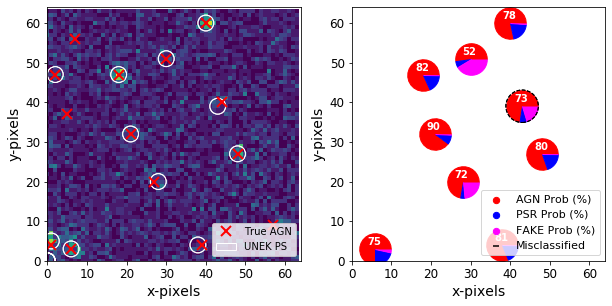

In [130]:
patch_two_plots(9, 2, False)

19
(64, 64, 5)
Patch center at lon = 45.00 and lat = 72.39


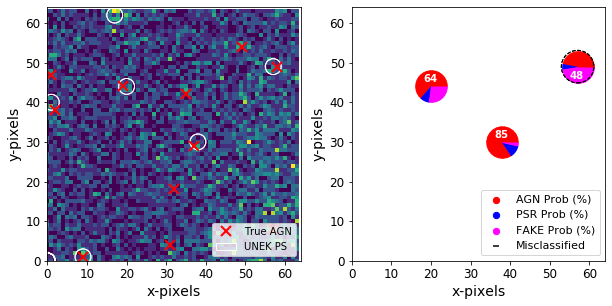

In [129]:
patch_two_plots(19, 2, False)

#### Notice that maybe there is a bit of distortion between cartesian and spherical coordinates when we inspect high latitude patches